<a href="https://colab.research.google.com/github/emgoss/PLP6621C/blob/main/Module6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Module 6 Assignment: Filtering SNPs

We will do some basic filtering of SNPs stored in a VCF file using VCFtools, following the code from this tutorial: https://speciationgenomics.github.io/filtering_vcfs/

BCFtools is a more powerful program for SNP filtering than the older VCFtools, but also a bit more complex to use. For large data sets, you may need BCFtools.

The R package vcfR can also be used for small datasets, see tutorial here: https://grunwaldlab.github.io/Population_Genetics_in_R/intro_vcf.html



**1. Install VCFtools.**
We will run the code using bash scripts.

In [ ]:
%%bash
# Clone the VCFtools repository
git clone https://github.com/vcftools/vcftools.git

# Navigate into the vcftools directory
cd vcftools

# Set PERL5LIB to ensure Perl scripts can find necessary modules
export PERL5LIB=/content/vcftools/src/perl

# Generate configure script and other build files
./autogen.sh

# Configure the build for your system
./configure

# Compile the software
make

# Install the compiled software to system directories
make install

Installing BCFtools and htslib helped get the file into a format that VCFtools can read.

In [ ]:
%%bash
git clone https://github.com/samtools/htslib.git
cd htslib
git submodule update --init --recursive # Initialize and update submodules
make
make install

In [ ]:
%%bash
git clone https://github.com/samtools/bcftools.git
cd bcftools
make
make install

cd ../htslib && make lib-static
make[1]: Entering directory '/content/htslib'
make[1]: Leaving directory '/content/htslib'
cd ../htslib && make lib-static
make[1]: Entering directory '/content/htslib'
make[1]: Leaving directory '/content/htslib'
mkdir -p -m 755 /usr/local/bin /usr/local/share/man/man1 /usr/local/libexec/bcftools
install -p bcftools /usr/local/bin
install -p misc/color-chrs.pl misc/gff2gff misc/gff2gff.py misc/guess-ploidy.py misc/plot-vcfstats misc/plot-roh.py misc/roh-viz misc/run-roh.pl misc/vcfutils.pl misc/vrfs-variances /usr/local/bin
install -p -m 644 doc/bcftools.1 /usr/local/share/man/man1
install -p plugins/*.so /usr/local/libexec/bcftools


fatal: destination path 'bcftools' already exists and is not an empty directory.


Verify installations

In [ ]:
%%bash
/usr/local/bin/vcftools --version
/usr/local/bin/bgzip --version
/usr/local/bin/bcftools --version

VCFtools (0.1.18)
bgzip (htslib) 1.23-9-gacc28ac1
Copyright (C) 2025 Genome Research Ltd.
bcftools 1.23-2-gde0606d1
Using htslib 1.23-9-gacc28ac1
Copyright (C) 2025 Genome Research Ltd.
License Expat: The MIT/Expat license
This is free software: you are free to change and redistribute it.
There is NO WARRANTY, to the extent permitted by law.


**2. Obtain the data.** Download the VCF file and convert to indexed bcvf.

These are Genotyping by Sequencing (GBS) data from Tabima et al. 2018. GBS is notorious for having many missing SNPs because different parts of the genome may be sequenced in different isolates.

I had to use multiple steps to convert the file into something VCFtools can read. I don't know why it couldn't handle the original version.

In [ ]:
%%bash
# Download the VCF file
wget "https://github.com/grunwaldlab/rubi-gbs/raw/refs/heads/master/rubi.out.vcf.gz" -O /content/rubi.vcf.gz

# Decompress the original VCF file to a temporary uncompressed file
gunzip -c /content/rubi.vcf.gz > /content/rubi_temp.vcf

# Re-compress the temporary uncompressed VCF file to BGZF format
/content/htslib/bgzip /content/rubi_temp.vcf

# Rename the BGZF compressed file back to the original name (it will overwrite)
mv /content/rubi_temp.vcf.gz /content/rubi.vcf.gz

# Now, index the correctly BGZF-compressed file using bcftools
/content/bcftools/bcftools index /content/rubi.vcf.gz

--2026-02-15 23:42:11--  https://github.com/grunwaldlab/rubi-gbs/raw/refs/heads/master/rubi.out.vcf.gz
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/grunwaldlab/rubi-gbs/refs/heads/master/rubi.out.vcf.gz [following]
--2026-02-15 23:42:11--  https://raw.githubusercontent.com/grunwaldlab/rubi-gbs/refs/heads/master/rubi.out.vcf.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1497045 (1.4M) [application/octet-stream]
Saving to: ‘/content/rubi.vcf.gz’

     0K .......... .......... .......... .......... ..........  3% 4.17M 0s
    50K .......... .......... .......... .......... ..........  6% 5.

**3. Obtain quality statistics.**
We will look at read depth by sample and by site, quality scores by site, and missing data by sample and site. These data are output to a file for visualization.

See this page for a list of commands: https://vcftools.github.io/man_latest.html

In [ ]:
%%bash
# Define variables for input and output paths within the same shell context
VCF=/content/rubi.vcf.gz
OUT=/content/rubi_unfiltered_output

# Run a VCFtools command to generate site quality statistics
# Using /usr/local/bin/vcftools as per the installation path

#individual depth
/usr/local/bin/vcftools --gzvcf $VCF --depth --out $OUT

#site depth
/usr/local/bin/vcftools --gzvcf $VCF --site-mean-depth --out $OUT

#SNP quality
/usr/local/bin/vcftools --gzvcf $VCF --site-quality --out $OUT

#missing data by individual
/usr/local/bin/vcftools --gzvcf $VCF --missing-indv --out $OUT

#missing data by site
/usr/local/bin/vcftools --gzvcf $VCF --missing-site --out $OUT


Process is interrupted.


Check that outfiles were created.

In [ ]:
ls -lh $OUT

total 2.7M
drwxr-xr-x 12 root root 4.0K Feb 15 23:07 bcftools/
drwxr-xr-x 12 root root 4.0K Feb 15 23:07 htslib/
-rw-r--r--  1 root root 526K Feb 15 23:16 rubi_filtered.vcf.gz
-rw-r--r--  1 root root 2.4K Feb 15 23:42 rubi_unfiltered_output.idepth
-rw-r--r--  1 root root 3.5K Feb 15 23:42 rubi_unfiltered_output.imiss
-rw-r--r--  1 root root 186K Feb 15 23:42 rubi_unfiltered_output.ldepth.mean
-rw-r--r--  1 root root 206K Feb 15 23:42 rubi_unfiltered_output.lmiss
-rw-r--r--  1 root root 143K Feb 15 23:42 rubi_unfiltered_output.lqual
-rw-r--r--  1 root root 1.6M Feb 15 23:42 rubi.vcf.gz
-rw-r--r--  1 root root  30K Feb 15 23:42 rubi.vcf.gz.csi
drwxr-xr-x  1 root root 4.0K Jan 16 14:24 sample_data/
drwxr-xr-x  7 root root 4.0K Feb 15 23:42 vcftools/


**4. Install R.**
To avoid using a separate notebook for visualization of the quality statistics using R code, we will use rpy to run R in this Python notebook.

In [ ]:
import sys
!{sys.executable} -m pip install 'rpy2==3.5.11'

Load the rpy2 package.

In [7]:
%load_ext rpy2.ipython

**5. Load R packages.** Now we will run R using %%R.

In [8]:
%%R
install.packages("tidyverse")
library("tidyverse")

(as ‘lib’ is unspecified)







	‘/tmp/RtmphIzjcj/downloaded_packages’



── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.2
✔ purrr     1.2.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


**6. Graph the distribution of per site SNP quality scores.**

Rows: 5632 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): chr
dbl (2): pos, qual

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


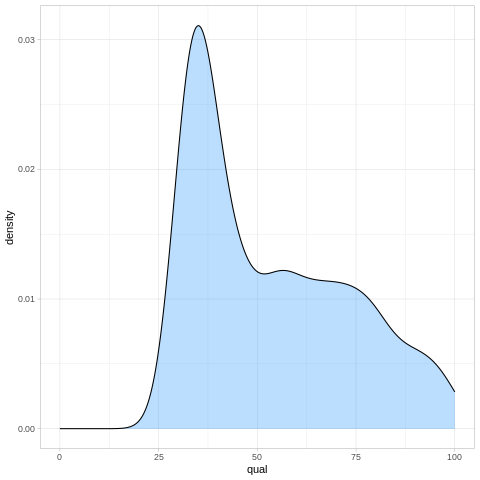

In [9]:
%%R
var_qual <- read_delim("/content/rubi_unfiltered_output.lqual", delim = "\t",
           col_names = c("chr", "pos", "qual"), skip = 1)
a <- ggplot(var_qual, aes(qual)) + geom_density(fill = "dodgerblue1", colour = "black", alpha = 0.3)
a + theme_light() + xlim(0, 100)

**7. Examine read depth per site (across individuals).**

Rows: 5632 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): chr
dbl (3): pos, mean_depth, var_depth

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


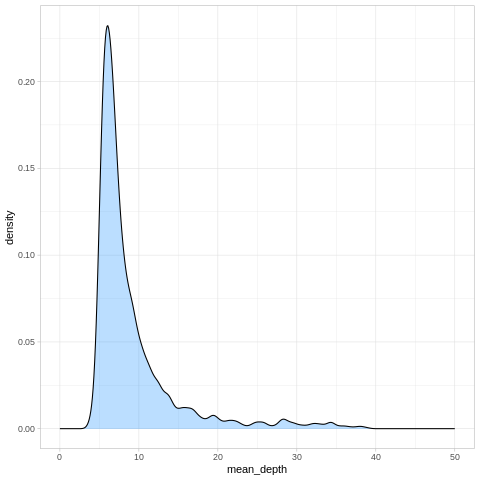

In [10]:
%%R
var_depth <- read_delim("/content/rubi_unfiltered_output.ldepth.mean", delim = "\t",
           col_names = c("chr", "pos", "mean_depth", "var_depth"), skip = 1)
a <- ggplot(var_depth, aes(mean_depth)) + geom_density(fill = "dodgerblue1", colour = "black", alpha = 0.3)
a + theme_light() + xlim(0, 50)



In [11]:
%%R
summary(var_depth$mean_depth)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  4.000   6.000   7.137   9.128   9.773  39.000      15 


**8. Missing data (frequency of missing samples) per site.**

Rows: 5632 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): chr
dbl (5): pos, nchr, nfiltered, nmiss, fmiss

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


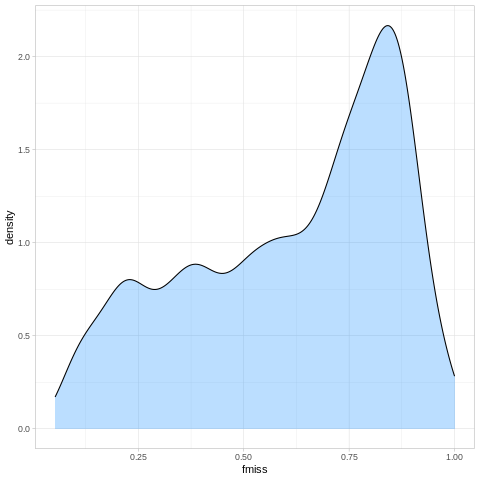

In [12]:
%%R
var_miss <- read_delim("/content/rubi_unfiltered_output.lmiss", delim = "\t",
                       col_names = c("chr", "pos", "nchr", "nfiltered", "nmiss", "fmiss"), skip = 1)
a <- ggplot(var_miss, aes(fmiss)) + geom_density(fill = "dodgerblue1", colour = "black", alpha = 0.3)
a + theme_light()

In [13]:
%%R
summary(var_miss$fmiss)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.05263 0.40602 0.67669 0.61259 0.82707 1.00000 


**9. Read depth by individual (across sites).**

Rows: 133 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (3): ind, nsites, depth

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`stat_bin()` using `bins = 30`. Pick better value `binwidth`.


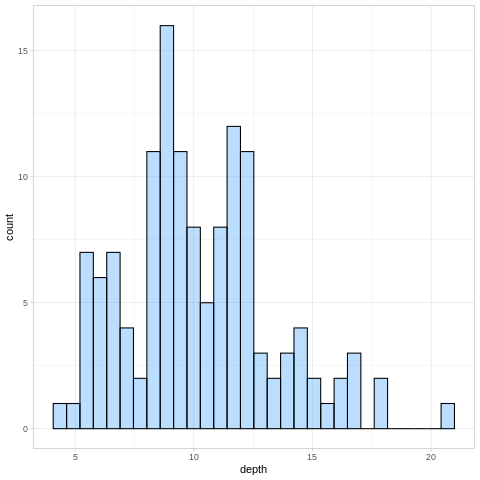

In [14]:
%%R
ind_depth <- read_delim("/content/rubi_unfiltered_output.idepth", delim = "\t",
                        col_names = c("ind", "nsites", "depth"), skip = 1)
a <- ggplot(ind_depth, aes(depth)) + geom_histogram(fill = "dodgerblue1", colour = "black", alpha = 0.3)
a + theme_light()

**10. Frequency of missing sites per individual.**

Rows: 133 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (5): ind, ndata, nfiltered, nmiss, fmiss

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`stat_bin()` using `bins = 30`. Pick better value `binwidth`.


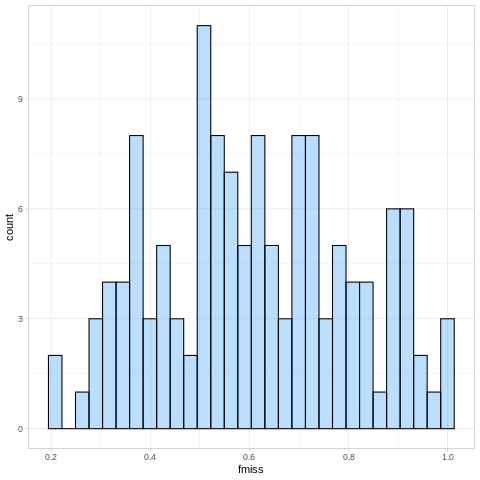

In [15]:
%%R
ind_miss  <- read_delim("/content/rubi_unfiltered_output.imiss", delim = "\t",
                        col_names = c("ind", "ndata", "nfiltered", "nmiss", "fmiss"), skip = 1)
a <- ggplot(ind_miss, aes(fmiss)) + geom_histogram(fill = "dodgerblue1", colour = "black", alpha = 0.3)
a + theme_light()

**11. Filter out indels and poor quality, low and high depth sites by site and individual.**

Some command explanation:

--gvcf - input path, denotes a gzipped vcf file

--remove-indels - remove all indels (SNPs only)

--max-missing - set minimum non-missing data. A little counterintuitive - 0 is totally missing, 1 is none missing. Here 0.9 means we will tolerate 10% missing data.

--minQ - this is the minimum quality score required for a site to pass our filtering threshold. Here we set it to 30.

--max-meanDP - the maximum mean depth for a site. High depth at a site can indicate a repetitive region in the genome.

--minDP - the minimum depth allowed for a genotype - any individual failing this threshold is marked as having a missing genotype.

--maxDP - the maximum depth allowed for a genotype - any individual failing this threshold is marked as having a missing genotype.

--recode - recode the output - necessary to output a vcf

--stdout - pipe the vcf out to the stdout (easier for file handling)

In [40]:
%%bash
# set filters
MISS=0.5
QUAL=30
MIN_DEPTH=4
MAX_DEPTH=50

/usr/local/bin/vcftools --gzvcf /content/rubi.vcf.gz \
--remove-indels --max-missing $MISS --minQ $QUAL \
--max-meanDP $MAX_DEPTH \
--minDP $MIN_DEPTH --maxDP $MAX_DEPTH --recode --stdout | gzip -c > \
/content/rubi_filtered.vcf.gz


VCFtools - 0.1.18
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /content/rubi.vcf.gz
	--maxDP 50
	--max-meanDP 50
	--minDP 10
	--minQ 30
	--max-missing 0.5
	--recode
	--remove-indels
	--stdout

Using zlib version: 1.2.11
After filtering, kept 133 out of 133 Individuals
Outputting VCF file...
After filtering, kept 422 out of a possible 5632 Sites
Run Time = 1.00 seconds


How many SNPs remain after filtering?

**12. Assess missingness by individual.**
We replaced genotypes with missing data if they didn't meet our quality metrics. Now, some of our isolates will have a lot of missing data. Determine which individuals should be removed due to high frequency of missing data (meaning missing information for SNPs).

We will start by identifying individuals with more than 50% of sites missing.

In [38]:
%%bash
mawk '$5 > 0.5' /content/rubi_unfiltered_output.imiss | cut -f1

INDV
4671
4798
4799
4801
4803
4805
4807
4808
4810
4811
4812
4813
4814
4815
4816
4817
4821
4822
4823
4825
4826
4827
4828
4829
4830
4831
4833
4834
4837
4839
4840
4845
4953
4958
4962
4967
4968
4971
4973
4975
4980
4982
4984
4985
4987
4992
4993
5031
5079
5080
5081
5082
5083
5084
5087
5089
5090
5091
5093
5095
5097
5098
5099
5102
5103
5104
5106
5107
5114
5115
5116
5117
5119
5120
5122
5126
5135
5137
5138
5139
5140
5142
5143
5295
5296
5343
5350
5351
5352
5353
5354
5355
5356
5357


Count the number of individuals with fmiss > 0.5.

In [39]:
%%bash
count=$(mawk '$5 > 0.5' /content/rubi_unfiltered_output.imiss | tail -n +2 | wc -l)
echo "Number of individuals with fmiss > 0.5: $count"

Number of individuals with fmiss > 0.5: 94


How many individuals were in the original data set?

What threshold would we need to retain about 100 isolates for analysis?